# PolyaStrength model development

**Purpose**: To develop a model that can predict the strength (inferred from expression) of *S. cerevisiae* polyadenylation sites in genomic sequences.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import models

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyastrength_model_development')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
with open(os.path.join(RESOURCES, 'polyastrength_configurations.pickle'), mode = 'rb') as handle:
    configurations = pickle.load(handle)


In [7]:
boxplot_format = {
    'boxprops' : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops' : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops' : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops' : {'color' : 'black'},
    'showfliers' : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5
}

## HELPER FUNCTIONS

In [8]:
def create_pairs(data, score_field, pairtype, log2fold = 0, distance = 0, max_dist = 1e4, max_iter = 10, random_seed = 12345):
    
    gene_sum = data['gene'].value_counts()
    gene_list = gene_sum[gene_sum > 1].index.to_list()
    filt = data.loc[data['gene'].isin(gene_list)].copy()
    
    counters = {
        'minimum_read_difference' : 0,
        'minimum_distance'        : 0,
        'iteration_limit'         : 0,
    }
    
    if (pairtype == 'top'):
        pair_data = filt.sort_values(f'{score_field}_reads').groupby('gene', as_index = False).tail(2)
        
    else:
        
        pair_dict = {}
        pair_columns = data.columns
        
        for gene_name in tqdm.tqdm(gene_list):
            
            n_iter = 0
            diff   = 0
            dist   = 0
            
            gene_data = filt.loc[filt['gene'] == gene_name]
            
            max_diff = np.abs(np.log2(gene_data[f'{score_field}_reads'].max() / gene_data[f'{score_field}_reads'].min()))
            max_dist = np.abs(gene_data['start'].max() - gene_data['start'].min())
            
            if (max_diff < log2fold):
                counters['minimum_read_difference'] += 1
                continue
            
            if (max_dist < distance):
                counters['minimum_distance'] += 1
                continue
                
            if (pairtype == 'random'):
                
                while (n_iter < max_iter) & ((diff <= log2fold) | (dist <= distance) | (dist > max_dist)):
                    
                    pair_data = gene_data.sample(n = 2, replace = False, random_state = random_seed + n_iter)
                    
                    diff = np.abs(np.log2(pair_data.iloc[0][f'{score_field}_reads'] / pair_data.iloc[1][f'{score_field}_reads']))
                    dist = np.abs(pair_data.iloc[0]['start'] - pair_data.iloc[1]['start'])

                    n_iter += 1
                    
                if (n_iter >= max_iter):
                    counters['iteration_limit'] += 1
                    continue
                    
                pair_dict[pair_data.index[0]] = pair_data.iloc[0].to_list()
                pair_dict[pair_data.index[1]] = pair_data.iloc[1].to_list()
                    
            elif (pairtype == 'mixed'):
                
                top_site = gene_data.sort_values(f'{score_field}_reads', ascending = True).tail(1)
                
                while (n_iter < max_iter) & ((diff <= log2fold) | (dist <= distance) | (dist > max_dist)):
                    
                    rand_site = gene_data.loc[gene_data['key'] != top_site.iloc[0]['key']].sample(n = 1, replace = False, random_state = int(random_seed + n_iter))
                    
                    diff = np.abs(np.log2(top_site.iloc[0][f'{score_field}_reads'] / rand_site.iloc[0][f'{score_field}_reads']))
                    dist = np.abs(top_site['start'].max() - rand_site['start'].max())
                    
                    n_iter += 1
                    
                if (n_iter >= max_iter):
                    counters['iteration_limit'] += 1
                    continue
                
                pair_dict[top_site.index[0]]  = top_site.iloc[0].to_list()
                pair_dict[rand_site.index[0]] = rand_site.iloc[0].to_list()
                
        pair_data = pd.DataFrame.from_dict(pair_dict, orient = 'index', columns = pair_columns)
        
    print(f"Pair generation complete: sites={len(pair_data)}, genes={pair_data['gene'].nunique()}")
    print("Skip counters:", counters)
    
    return categorize_pairs(pair_data, score_field)


In [9]:
def categorize_pairs(data, score_field):
    '''Categorize the sites in each pair based on their relative position (i.e. proximal or distal) and supporting reads (i.e. major or minor).
    '''

    out_data = data.copy()

    out_data['category_pos']   = 'distal'
    out_data['category_reads'] = 'minor'
    out_data['category_pred']  = 'minor'

    out_data.loc[out_data.loc[out_data['strand'] == '+'].groupby('gene').start.idxmin(), 'category_pos'] = 'proximal'
    out_data.loc[out_data.loc[out_data['strand'] == '-'].groupby('gene').start.idxmax(), 'category_pos'] = 'proximal'

    out_data.loc[out_data.groupby('gene')[f'{score_field}_reads'].idxmax(), 'category_reads'] = 'major'
    out_data.loc[out_data.groupby('gene')['pred_logit'].idxmax(), 'category_pred'] = 'major'

    site_summary = (out_data.loc[(out_data['category_reads'] == 'major')].shape[0], 
                    out_data.loc[(out_data['category_reads'] == 'major') & (out_data['category_pos'] == 'proximal')].shape[0], 
                    out_data.loc[(out_data['category_reads'] == 'major') & (out_data['category_pos'] == 'distal')].shape[0], 
                   )

    return out_data, site_summary


In [10]:
def calculate_pairs_auc(pair_data):
    
    ## Compile a dictionary of sites that will map the position to the prediction
    
    matched_sites = {}
    
    for i,row in pair_data.iterrows():
        if (row['gene'] not in matched_sites):
            matched_sites[row['gene']] = {}
        matched_sites[row['gene']][row['category_reads']] = row['pred_logit']
        
    ## For each site in all pairs, find the predictions for the matching site and calculate the difference
    
    out_data = pair_data.copy()
    
    out_data['matched_cat'] = 'major'
    out_data.loc[out_data['category_reads'] == 'major', 'matched_cat'] = 'minor'
    
    out_data['binary_class'] = (out_data['category_reads'] == 'major').astype(int)
    out_data['matched_pred'] = out_data.apply(lambda row: matched_sites[row['gene']][row['matched_cat']], axis = 1)
    out_data['matched_diff'] = out_data['pred_logit'] - out_data['matched_pred']

    ## Calculate the AUROC and AUPRC for all pairs

    auroc, auprc  = models.calculate_auc(out_data['binary_class'], out_data['matched_diff'])

    return auroc, auprc
    
    

## ANALYSIS

#### Load test split data for PolyaStrength model

In [11]:
dt_tr = pd.read_csv(os.path.join(RESOURCES, 'polyastrength_final_model.train_data.txt'), sep = "\t")
dt_va = pd.read_csv(os.path.join(RESOURCES, 'polyastrength_final_model.val_data.txt'),   sep = "\t")
dt_te = pd.read_csv(os.path.join(RESOURCES, 'polyastrength_final_model.test_data.txt'),  sep = "\t")

print(f"Train     : {dt_tr.shape}")
print(f"Validation: {dt_va.shape}")
print(f"Test      : {dt_te.shape}")

dt_tr['chrom']  = dt_tr['key'].str.split(":").str[0].astype(str)
dt_tr['start']  = dt_tr['key'].str.split(":").str[1].astype(int)
dt_tr['strand'] = dt_tr['key'].str.split(":").str[2].astype(str)

dt_va['chrom']  = dt_va['key'].str.split(":").str[0].astype(str)
dt_va['start']  = dt_va['key'].str.split(":").str[1].astype(int)
dt_va['strand'] = dt_va['key'].str.split(":").str[2].astype(str)

dt_te['chrom']  = dt_te['key'].str.split(":").str[0].astype(str)
dt_te['start']  = dt_te['key'].str.split(":").str[1].astype(int)
dt_te['strand'] = dt_te['key'].str.split(":").str[2].astype(str)


Train     : (14488, 11)
Validation: (2054, 11)
Test      : (4149, 11)


In [12]:
dt_tr['pred_prob'] = dt_tr['pred_logit'].apply(lambda x : (2 ** x) / (1 + (2 ** x)))
dt_va['pred_prob'] = dt_va['pred_logit'].apply(lambda x : (2 ** x) / (1 + (2 ** x)))
dt_te['pred_prob'] = dt_te['pred_logit'].apply(lambda x : (2 ** x) / (1 + (2 ** x)))


In [13]:
dt_tr['usage_bins'] = pd.cut(dt_tr['raw_den_score'], bins=[0,0.2,0.5,0.8,1.0], labels = ['<0.2','0.2-0.5','0.5-0.8','>0.8'], right = False)
dt_va['usage_bins'] = pd.cut(dt_va['raw_den_score'], bins=[0,0.2,0.5,0.8,1.0], labels = ['<0.2','0.2-0.5','0.5-0.8','>0.8'], right = False)
dt_te['usage_bins'] = pd.cut(dt_te['raw_den_score'], bins=[0,0.2,0.5,0.8,1.0], labels = ['<0.2','0.2-0.5','0.5-0.8','>0.8'], right = False)

print(dt_te['usage_bins'].value_counts())


<0.2       2392
0.2-0.5     798
0.5-0.8     584
>0.8        375
Name: usage_bins, dtype: int64


## Discriminating strong from weak sites

### Generate pairs of sites

In [14]:
aucs = {
    'split'     : [],
    'iteration' : [],
    'auroc'     : [],
    'auprc'     : [],
}

for split,sdata in zip(['Train','Validation','Test'], [dt_tr, dt_va, dt_te]):
    print(f"\n\n## SPLIT {split}")

    for i in range(10):
        print(f"\nIteration {i}")

        pairs, _ = create_pairs(sdata, 'cluster', 'mixed', log2fold = 3, distance = 0, max_iter = 10, random_seed = int(12345*i))
        auroc, auprc = calculate_pairs_auc(pairs)
        
        aucs['split'].append(split)
        aucs['iteration'].append(i)
        aucs['auroc'].append(auroc)
        aucs['auprc'].append(auprc)

aucs = pd.DataFrame.from_dict(aucs, orient = 'columns')




## SPLIT Train

Iteration 0


100%|██████████| 3362/3362 [00:17<00:00, 193.87it/s]


Pair generation complete: sites=4894, genes=2447
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 41}

Iteration 1


100%|██████████| 3362/3362 [00:17<00:00, 197.49it/s]


Pair generation complete: sites=4968, genes=2484
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 4}

Iteration 2


100%|██████████| 3362/3362 [00:17<00:00, 192.47it/s]


Pair generation complete: sites=4962, genes=2481
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 7}

Iteration 3


100%|██████████| 3362/3362 [00:17<00:00, 192.22it/s]


Pair generation complete: sites=4970, genes=2485
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 3}

Iteration 4


100%|██████████| 3362/3362 [00:17<00:00, 188.94it/s]


Pair generation complete: sites=4924, genes=2462
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 26}

Iteration 5


100%|██████████| 3362/3362 [00:19<00:00, 171.54it/s]


Pair generation complete: sites=4784, genes=2392
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 96}

Iteration 6


100%|██████████| 3362/3362 [00:17<00:00, 192.20it/s]


Pair generation complete: sites=4918, genes=2459
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 29}

Iteration 7


100%|██████████| 3362/3362 [00:17<00:00, 191.24it/s]


Pair generation complete: sites=4946, genes=2473
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 15}

Iteration 8


100%|██████████| 3362/3362 [00:16<00:00, 200.00it/s]


Pair generation complete: sites=4960, genes=2480
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 8}

Iteration 9


100%|██████████| 3362/3362 [00:17<00:00, 189.88it/s]


Pair generation complete: sites=4966, genes=2483
Skip counters: {'minimum_read_difference': 874, 'minimum_distance': 0, 'iteration_limit': 5}


## SPLIT Validation

Iteration 0


100%|██████████| 470/470 [00:02<00:00, 228.91it/s]


Pair generation complete: sites=656, genes=328
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 6}

Iteration 1


100%|██████████| 470/470 [00:01<00:00, 238.31it/s]


Pair generation complete: sites=668, genes=334
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 0}

Iteration 2


100%|██████████| 470/470 [00:02<00:00, 227.85it/s]


Pair generation complete: sites=666, genes=333
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 1}

Iteration 3


100%|██████████| 470/470 [00:02<00:00, 232.63it/s]


Pair generation complete: sites=668, genes=334
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 0}

Iteration 4


100%|██████████| 470/470 [00:02<00:00, 220.20it/s]


Pair generation complete: sites=660, genes=330
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 4}

Iteration 5


100%|██████████| 470/470 [00:02<00:00, 206.28it/s]


Pair generation complete: sites=638, genes=319
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 15}

Iteration 6


100%|██████████| 470/470 [00:02<00:00, 219.58it/s]


Pair generation complete: sites=656, genes=328
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 6}

Iteration 7


100%|██████████| 470/470 [00:02<00:00, 227.50it/s]


Pair generation complete: sites=664, genes=332
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 2}

Iteration 8


100%|██████████| 470/470 [00:01<00:00, 242.86it/s]


Pair generation complete: sites=668, genes=334
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 0}

Iteration 9


100%|██████████| 470/470 [00:02<00:00, 218.71it/s]


Pair generation complete: sites=668, genes=334
Skip counters: {'minimum_read_difference': 136, 'minimum_distance': 0, 'iteration_limit': 0}


## SPLIT Test

Iteration 0


100%|██████████| 959/959 [00:04<00:00, 212.37it/s]


Pair generation complete: sites=1420, genes=710
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 13}

Iteration 1


100%|██████████| 959/959 [00:04<00:00, 227.07it/s]


Pair generation complete: sites=1444, genes=722
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 1}

Iteration 2


100%|██████████| 959/959 [00:04<00:00, 211.03it/s]


Pair generation complete: sites=1444, genes=722
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 1}

Iteration 3


100%|██████████| 959/959 [00:04<00:00, 214.52it/s]


Pair generation complete: sites=1446, genes=723
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 0}

Iteration 4


100%|██████████| 959/959 [00:04<00:00, 205.70it/s]


Pair generation complete: sites=1432, genes=716
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 7}

Iteration 5


100%|██████████| 959/959 [00:05<00:00, 187.21it/s]


Pair generation complete: sites=1386, genes=693
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 30}

Iteration 6


100%|██████████| 959/959 [00:04<00:00, 214.61it/s]


Pair generation complete: sites=1430, genes=715
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 8}

Iteration 7


100%|██████████| 959/959 [00:04<00:00, 217.07it/s]


Pair generation complete: sites=1442, genes=721
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 2}

Iteration 8


100%|██████████| 959/959 [00:04<00:00, 224.19it/s]


Pair generation complete: sites=1444, genes=722
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 1}

Iteration 9


100%|██████████| 959/959 [00:04<00:00, 202.26it/s]


Pair generation complete: sites=1444, genes=722
Skip counters: {'minimum_read_difference': 236, 'minimum_distance': 0, 'iteration_limit': 1}


### Performance by training split

In [15]:
aucs_summary = aucs.groupby('split').agg({'auroc' : ['mean','std'], 'auprc' : ['mean','std']}).loc[['Train','Validation','Test']]
print(aucs_summary)


               auroc               auprc          
                mean       std      mean       std
split                                             
Train       0.986651  0.000834  0.986891  0.000851
Validation  0.964015  0.003781  0.963310  0.004527
Test        0.941635  0.001629  0.942219  0.002315


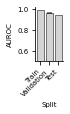

In [16]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

ax.bar(aucs_summary.index, aucs_summary['auroc']['mean'], **barplot_format)
ax.errorbar(x = aucs_summary.index, y = aucs_summary['auroc']['mean'], 
            yerr = aucs_summary['auroc']['std'], fmt = 'none',
            ecolor = 'black', elinewidth=5, barsabove = True, 
           )

ax.set_xlabel('Split')
ax.set_xticks(aucs_summary.index)
ax.set_xticklabels(aucs_summary.index, rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel('AUROC')
ax.set_ylim(0.5,1.02)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'performance_by_split.auroc.svg'), format = 'svg', dpi = 600)
plt.show()


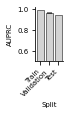

In [17]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

ax.bar(aucs_summary.index, aucs_summary['auprc']['mean'], **barplot_format)
ax.errorbar(x = aucs_summary.index, y = aucs_summary['auprc']['mean'], 
            yerr = aucs_summary['auprc']['std'], fmt = 'none',
            ecolor = 'black', elinewidth=5, barsabove = True, 
           )

ax.set_xlabel('Split')
ax.set_xticks(aucs_summary.index)
ax.set_xticklabels(aucs_summary.index, rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel('AUPRC')
ax.set_ylim(0.5,1.02)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'performance_by_split.auprc.svg'), format = 'svg', dpi = 600)
plt.show()


### Correlation between site usage and strength predictions

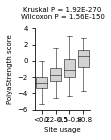

In [21]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

sns.boxplot(data = dt_te, x = 'usage_bins', y = 'pred_logit', 
            color = 'lightgray', **boxplot_format, ax = ax)

ks_stat, ks_pval = st.kruskal(dt_te.loc[dt_te['usage_bins'] == '<0.2',    'pred_logit'], 
                              dt_te.loc[dt_te['usage_bins'] == '0.2-0.5', 'pred_logit'],
                              dt_te.loc[dt_te['usage_bins'] == '0.5-0.8', 'pred_logit'],
                              dt_te.loc[dt_te['usage_bins'] == '>0.8',    'pred_logit'])

wr_stat, wr_pval = st.ranksums(dt_te.loc[dt_te['usage_bins'] == '<0.2',    'pred_logit'], 
                               dt_te.loc[dt_te['usage_bins'] == '>0.8',    'pred_logit'])

ax.text(0.5, 1.1, f'Kruskal P = {ks_pval:.02E}\nWilcoxon P = {wr_pval:.02E}', ha = 'center', va = 'bottom', transform = ax.transAxes)

ax.set_xlabel("Site usage")
ax.set_ylabel("PolyaStrength score")

ax.set_ylim(-6,4)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'predicted_strength_by_usage.boxplot.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
